# Age Regression from Brain MRI

Two different supervised learning approaches for age regression from brain MRI. Data from 600 healthy subjects.

## The Data

Some overview and visualisation of the statistics over the population of 600 subjects.

Load the data containing information about the subject IDs, their age, and gender.

In [2]:
# Read the meta data using pandas
import pandas as pd

data_dir = "path to data/"

meta_data = pd.read_csv(data_dir + 'clean_participant_data.csv')
meta_data.head()

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


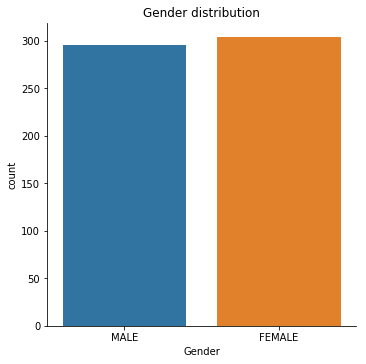

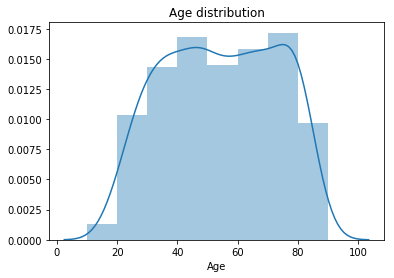

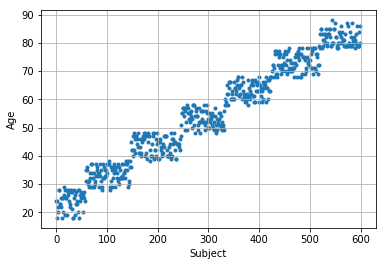

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

from utils.image_viewer import display_image

from sklearn import metrics

### Imaging data

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


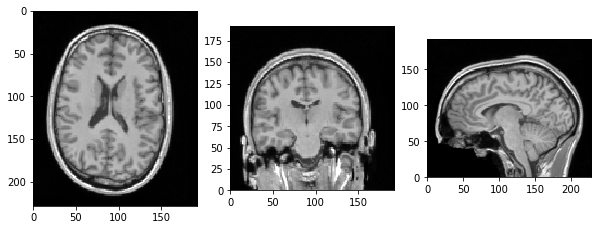

Brain mask (used in part A)


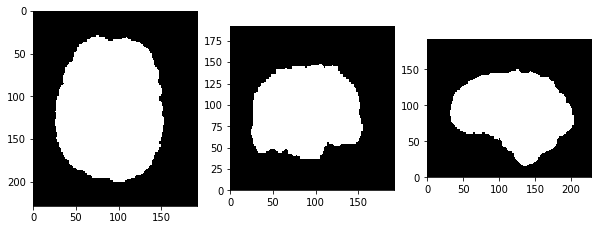

Spatially normalised grey matter maps (used in part B)


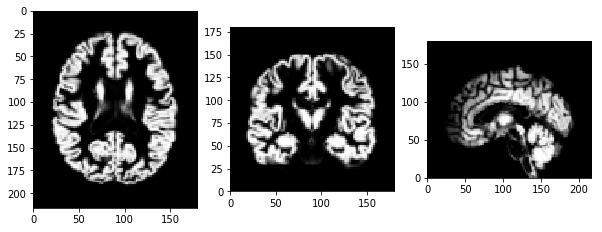

In [5]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

## Volume-based regression using brain structure segmentation

Regress the age of a subject using the volumes of brain tissues as features. The structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented and applied to the 600 brain scans. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

### Brain tissue segmentation

A CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF.

#### Imports

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.data_helper import ImageSegmentationDataset

#### Check that the GPU is up and running

In [7]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla K80


#### Config and hyper-parameters

In [8]:
rnd_seed = 42 #fixed random seed

# img_size = [128, 128, 128]
img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 4
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

Apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

In [9]:
# USE THIS FOR TRAINING ON ALL 47 SUBJECTS
train_data = data_dir + 'train/csv/train.csv'

# USE THIS FOR DEBUGGING WITH JUST 2 SUBJECTS
# train_data = data_dir + 'train/csv/train_debug.csv'

val_data = data_dir + 'train/csv/val.csv'

print('LOADING TRAINING DATA...')
dataset_train = ImageSegmentationDataset(train_data, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

print('\nLOADING VALIDATION DATA...')
dataset_val = ImageSegmentationDataset(val_data, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

LOADING TRAINING DATA...
+ reading image msub-CC110319_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110319.nii.gz
+ reading mask sub-CC110319_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120208_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120208.nii.gz
+ reading mask sub-CC120208_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC120462_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC120462.nii.gz
+ reading mask sub-CC120462_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC121144_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121144.nii.gz
+ reading mask sub-CC121144_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC122405_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC122405.nii.gz
+ reading mask sub-CC122405_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC210422_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC210422.nii.gz
+ reading mask sub-CC210422_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC220203_T1w_rigid

#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: msub-CC110319_T1w_rigid_to_mni.nii.gz


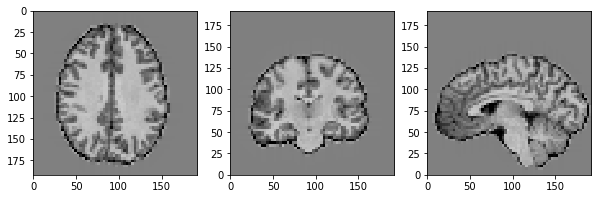

Segmentation: CC110319.nii.gz


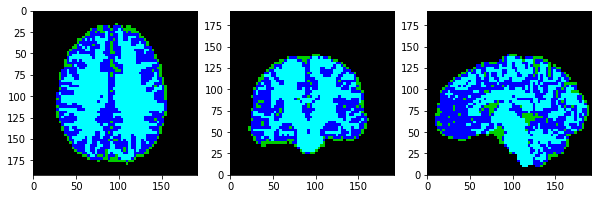

Mask


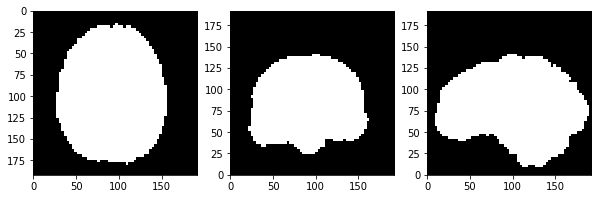

In [10]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

In [11]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv3d(1, 18, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(18, 36, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(36, 54, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(54, 27, kernel_size=1)
        self.conv5 = nn.Conv3d(27, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return F.softmax(x, dim=1)

#### TRAINING

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.229930
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.188562 	Time: 17.173074
DSC	0.1887462948551526


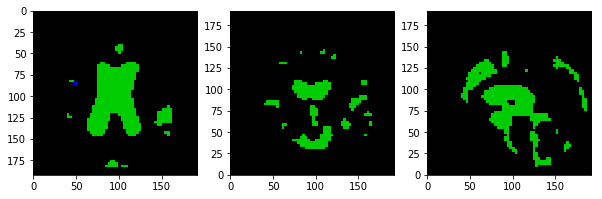

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.872511
+ TRAINING 	Epoch: 3 	Loss: 0.842169
+ TRAINING 	Epoch: 4 	Loss: 0.840396
+ TRAINING 	Epoch: 5 	Loss: 0.835717
+ TRAINING 	Epoch: 6 	Loss: 0.826876
+ TRAINING 	Epoch: 7 	Loss: 0.825030
+ TRAINING 	Epoch: 8 	Loss: 0.818294
+ TRAINING 	Epoch: 9 	Loss: 0.822773
+ TRAINING 	Epoch: 10 	Loss: 0.811307
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.822223 	Time: 169.954166
DSC	0.6690933765608478


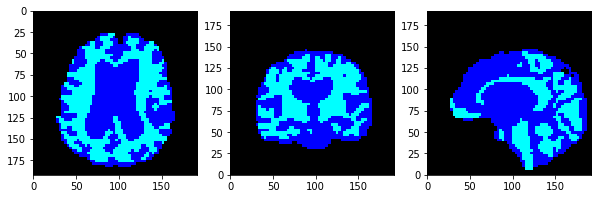

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.812752
+ TRAINING 	Epoch: 12 	Loss: 0.810590
+ TRAINING 	Epoch: 13 	Loss: 0.813111
+ TRAINING 	Epoch: 14 	Loss: 0.810729
+ TRAINING 	Epoch: 15 	Loss: 0.807958
+ TRAINING 	Epoch: 16 	Loss: 0.806675
+ TRAINING 	Epoch: 17 	Loss: 0.806372
+ TRAINING 	Epoch: 18 	Loss: 0.798685
+ TRAINING 	Epoch: 19 	Loss: 0.815937
+ TRAINING 	Epoch: 20 	Loss: 0.806181
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.811789 	Time: 341.255172
DSC	0.7111856768458671


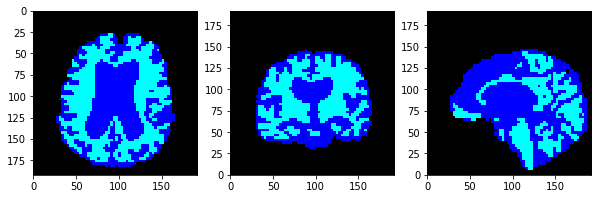

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.796506
+ TRAINING 	Epoch: 22 	Loss: 0.797091
+ TRAINING 	Epoch: 23 	Loss: 0.805497
+ TRAINING 	Epoch: 24 	Loss: 0.798363
+ TRAINING 	Epoch: 25 	Loss: 0.800462
+ TRAINING 	Epoch: 26 	Loss: 0.792722
+ TRAINING 	Epoch: 27 	Loss: 0.792261
+ TRAINING 	Epoch: 28 	Loss: 0.786099
+ TRAINING 	Epoch: 29 	Loss: 0.782417
+ TRAINING 	Epoch: 30 	Loss: 0.782994
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.784902 	Time: 512.661394
DSC	0.8326115842562446


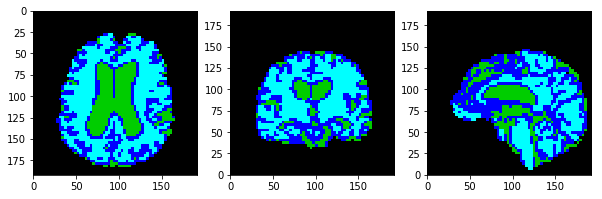

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.778088
+ TRAINING 	Epoch: 32 	Loss: 0.777878
+ TRAINING 	Epoch: 33 	Loss: 0.775787
+ TRAINING 	Epoch: 34 	Loss: 0.778423
+ TRAINING 	Epoch: 35 	Loss: 0.779409
+ TRAINING 	Epoch: 36 	Loss: 0.778551
+ TRAINING 	Epoch: 37 	Loss: 0.778065
+ TRAINING 	Epoch: 38 	Loss: 0.775737
+ TRAINING 	Epoch: 39 	Loss: 0.775506
+ TRAINING 	Epoch: 40 	Loss: 0.775027
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.780995 	Time: 683.919609
DSC	0.843789210978465


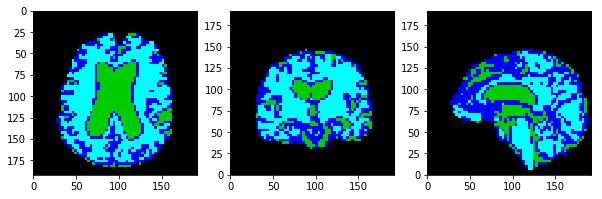

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.775712
+ TRAINING 	Epoch: 42 	Loss: 0.774946
+ TRAINING 	Epoch: 43 	Loss: 0.774344
+ TRAINING 	Epoch: 44 	Loss: 0.772837
+ TRAINING 	Epoch: 45 	Loss: 0.771259
+ TRAINING 	Epoch: 46 	Loss: 0.775367
+ TRAINING 	Epoch: 47 	Loss: 0.772607
+ TRAINING 	Epoch: 48 	Loss: 0.772896
+ TRAINING 	Epoch: 49 	Loss: 0.775150
+ TRAINING 	Epoch: 50 	Loss: 0.772654
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.775896 	Time: 855.386376
DSC	0.8666671000440388


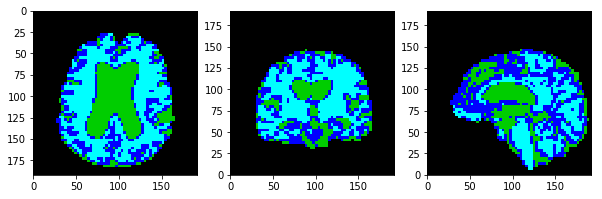

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.771759
+ TRAINING 	Epoch: 52 	Loss: 0.774002
+ TRAINING 	Epoch: 53 	Loss: 0.771399
+ TRAINING 	Epoch: 54 	Loss: 0.774904
+ TRAINING 	Epoch: 55 	Loss: 0.776264
+ TRAINING 	Epoch: 56 	Loss: 0.774715
+ TRAINING 	Epoch: 57 	Loss: 0.774725
+ TRAINING 	Epoch: 58 	Loss: 0.771668
+ TRAINING 	Epoch: 59 	Loss: 0.775373
+ TRAINING 	Epoch: 60 	Loss: 0.774977
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.774848 	Time: 1026.475206
DSC	0.8699170200200124


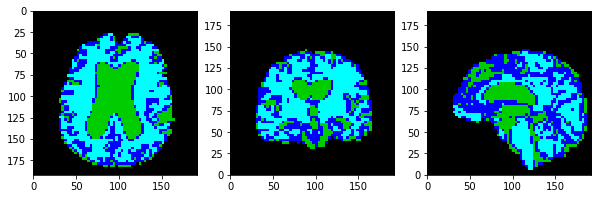

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.772892
+ TRAINING 	Epoch: 62 	Loss: 0.772741
+ TRAINING 	Epoch: 63 	Loss: 0.771755
+ TRAINING 	Epoch: 64 	Loss: 0.773381
+ TRAINING 	Epoch: 65 	Loss: 0.772918
+ TRAINING 	Epoch: 66 	Loss: 0.773151
+ TRAINING 	Epoch: 67 	Loss: 0.770131
+ TRAINING 	Epoch: 68 	Loss: 0.769743
+ TRAINING 	Epoch: 69 	Loss: 0.769737
+ TRAINING 	Epoch: 70 	Loss: 0.772247
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.773459 	Time: 1197.649762
DSC	0.8752786140693299


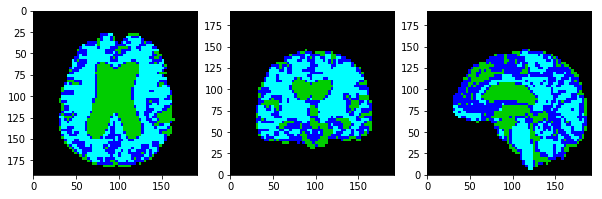

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.771197
+ TRAINING 	Epoch: 72 	Loss: 0.772430
+ TRAINING 	Epoch: 73 	Loss: 0.770703
+ TRAINING 	Epoch: 74 	Loss: 0.771834
+ TRAINING 	Epoch: 75 	Loss: 0.772284
+ TRAINING 	Epoch: 76 	Loss: 0.769083
+ TRAINING 	Epoch: 77 	Loss: 0.769516
+ TRAINING 	Epoch: 78 	Loss: 0.772671
+ TRAINING 	Epoch: 79 	Loss: 0.766728
+ TRAINING 	Epoch: 80 	Loss: 0.770979
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.774888 	Time: 1368.662950
DSC	0.8670126212420385


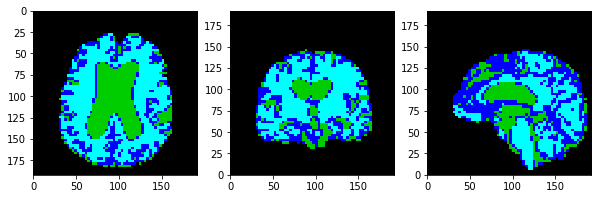

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.769058
+ TRAINING 	Epoch: 82 	Loss: 0.772520
+ TRAINING 	Epoch: 83 	Loss: 0.770833
+ TRAINING 	Epoch: 84 	Loss: 0.771484
+ TRAINING 	Epoch: 85 	Loss: 0.772005
+ TRAINING 	Epoch: 86 	Loss: 0.771688
+ TRAINING 	Epoch: 87 	Loss: 0.772027
+ TRAINING 	Epoch: 88 	Loss: 0.772998
+ TRAINING 	Epoch: 89 	Loss: 0.767728
+ TRAINING 	Epoch: 90 	Loss: 0.770848
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.772492 	Time: 1539.648258
DSC	0.8783727346337494


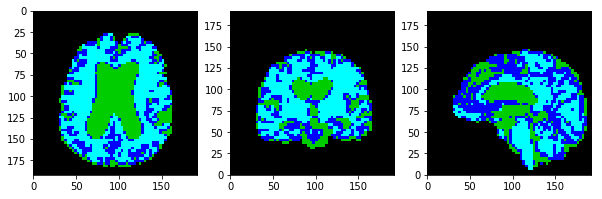

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.770269
+ TRAINING 	Epoch: 92 	Loss: 0.767729
+ TRAINING 	Epoch: 93 	Loss: 0.773504
+ TRAINING 	Epoch: 94 	Loss: 0.771511
+ TRAINING 	Epoch: 95 	Loss: 0.769213
+ TRAINING 	Epoch: 96 	Loss: 0.769578
+ TRAINING 	Epoch: 97 	Loss: 0.769886
+ TRAINING 	Epoch: 98 	Loss: 0.769751
+ TRAINING 	Epoch: 99 	Loss: 0.769543
+ TRAINING 	Epoch: 100 	Loss: 0.771080
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.771996 	Time: 1710.607319
DSC	0.8799650087972035


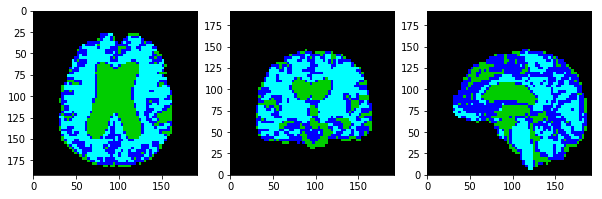

--------------------------------------------------
+ TRAINING 	Epoch: 101 	Loss: 0.770115
+ TRAINING 	Epoch: 102 	Loss: 0.771149
+ TRAINING 	Epoch: 103 	Loss: 0.771908
+ TRAINING 	Epoch: 104 	Loss: 0.767554
+ TRAINING 	Epoch: 105 	Loss: 0.770689
+ TRAINING 	Epoch: 106 	Loss: 0.767444
+ TRAINING 	Epoch: 107 	Loss: 0.768819
+ TRAINING 	Epoch: 108 	Loss: 0.771110
+ TRAINING 	Epoch: 109 	Loss: 0.770796
+ TRAINING 	Epoch: 110 	Loss: 0.769088
--------------------------------------------------
+ VALIDATE 	Epoch: 110 	Loss: 0.771498 	Time: 1881.578091
DSC	0.8819830090494056


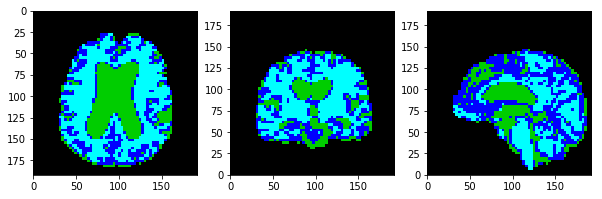

--------------------------------------------------
+ TRAINING 	Epoch: 111 	Loss: 0.768812
+ TRAINING 	Epoch: 112 	Loss: 0.770404
+ TRAINING 	Epoch: 113 	Loss: 0.769139
+ TRAINING 	Epoch: 114 	Loss: 0.769357
+ TRAINING 	Epoch: 115 	Loss: 0.769062
+ TRAINING 	Epoch: 116 	Loss: 0.769941
+ TRAINING 	Epoch: 117 	Loss: 0.772174
+ TRAINING 	Epoch: 118 	Loss: 0.770011
+ TRAINING 	Epoch: 119 	Loss: 0.770329
+ TRAINING 	Epoch: 120 	Loss: 0.770906
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 0.771479 	Time: 2052.370511
DSC	0.8816012955991898


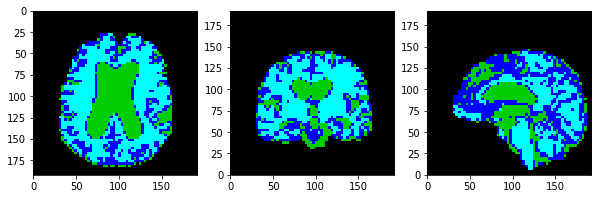

--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 0.770975
+ TRAINING 	Epoch: 122 	Loss: 0.771567
+ TRAINING 	Epoch: 123 	Loss: 0.768481
+ TRAINING 	Epoch: 124 	Loss: 0.769649
+ TRAINING 	Epoch: 125 	Loss: 0.770674
+ TRAINING 	Epoch: 126 	Loss: 0.768200
+ TRAINING 	Epoch: 127 	Loss: 0.770872
+ TRAINING 	Epoch: 128 	Loss: 0.769193
+ TRAINING 	Epoch: 129 	Loss: 0.770875
+ TRAINING 	Epoch: 130 	Loss: 0.770110
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 0.772345 	Time: 2223.210756
DSC	0.876893519300918


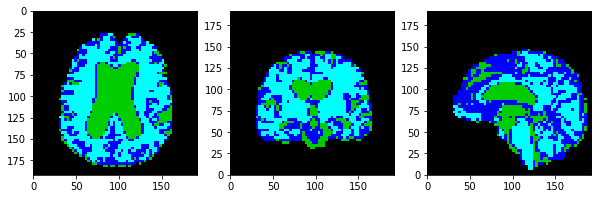

--------------------------------------------------
+ TRAINING 	Epoch: 131 	Loss: 0.767041
+ TRAINING 	Epoch: 132 	Loss: 0.767716
+ TRAINING 	Epoch: 133 	Loss: 0.765535
+ TRAINING 	Epoch: 134 	Loss: 0.768821
+ TRAINING 	Epoch: 135 	Loss: 0.767818
+ TRAINING 	Epoch: 136 	Loss: 0.770124
+ TRAINING 	Epoch: 137 	Loss: 0.770144
+ TRAINING 	Epoch: 138 	Loss: 0.768336
+ TRAINING 	Epoch: 139 	Loss: 0.769318
+ TRAINING 	Epoch: 140 	Loss: 0.772699
--------------------------------------------------
+ VALIDATE 	Epoch: 140 	Loss: 0.770821 	Time: 2394.158781
DSC	0.8838418023208021


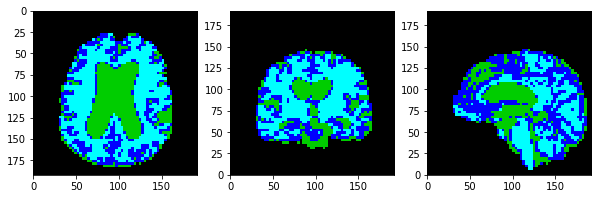

--------------------------------------------------
+ TRAINING 	Epoch: 141 	Loss: 0.768998
+ TRAINING 	Epoch: 142 	Loss: 0.769562
+ TRAINING 	Epoch: 143 	Loss: 0.772746
+ TRAINING 	Epoch: 144 	Loss: 0.768379
+ TRAINING 	Epoch: 145 	Loss: 0.770333
+ TRAINING 	Epoch: 146 	Loss: 0.767623
+ TRAINING 	Epoch: 147 	Loss: 0.766394
+ TRAINING 	Epoch: 148 	Loss: 0.768516
+ TRAINING 	Epoch: 149 	Loss: 0.768519
+ TRAINING 	Epoch: 150 	Loss: 0.769720
--------------------------------------------------
+ VALIDATE 	Epoch: 150 	Loss: 0.771633 	Time: 2564.771925
DSC	0.8792097028675402


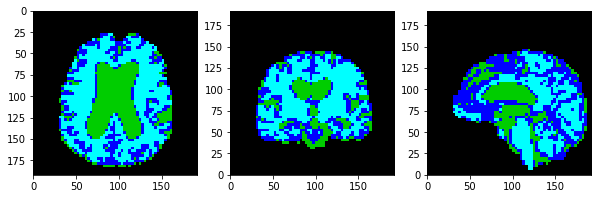

--------------------------------------------------
+ TRAINING 	Epoch: 151 	Loss: 0.766170
+ TRAINING 	Epoch: 152 	Loss: 0.768105
+ TRAINING 	Epoch: 153 	Loss: 0.768837
+ TRAINING 	Epoch: 154 	Loss: 0.768510
+ TRAINING 	Epoch: 155 	Loss: 0.768573
+ TRAINING 	Epoch: 156 	Loss: 0.769333
+ TRAINING 	Epoch: 157 	Loss: 0.766485
+ TRAINING 	Epoch: 158 	Loss: 0.768792
+ TRAINING 	Epoch: 159 	Loss: 0.767608
+ TRAINING 	Epoch: 160 	Loss: 0.768400
--------------------------------------------------
+ VALIDATE 	Epoch: 160 	Loss: 0.770493 	Time: 2735.291732
DSC	0.884857556454618


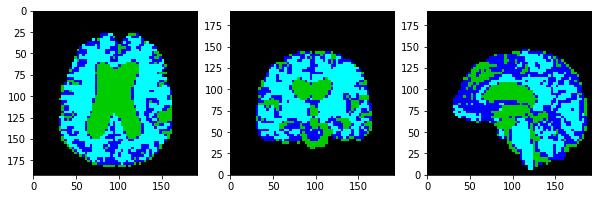

--------------------------------------------------
+ TRAINING 	Epoch: 161 	Loss: 0.769935
+ TRAINING 	Epoch: 162 	Loss: 0.768230
+ TRAINING 	Epoch: 163 	Loss: 0.765899
+ TRAINING 	Epoch: 164 	Loss: 0.768474
+ TRAINING 	Epoch: 165 	Loss: 0.767675
+ TRAINING 	Epoch: 166 	Loss: 0.768505
+ TRAINING 	Epoch: 167 	Loss: 0.769228
+ TRAINING 	Epoch: 168 	Loss: 0.770220
+ TRAINING 	Epoch: 169 	Loss: 0.767345
+ TRAINING 	Epoch: 170 	Loss: 0.767782
--------------------------------------------------
+ VALIDATE 	Epoch: 170 	Loss: 0.771067 	Time: 2906.120534
DSC	0.8817688272490628


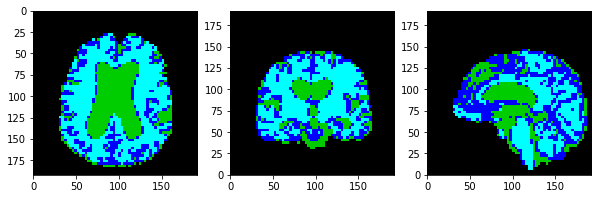

--------------------------------------------------
+ TRAINING 	Epoch: 171 	Loss: 0.766861
+ TRAINING 	Epoch: 172 	Loss: 0.767854
+ TRAINING 	Epoch: 173 	Loss: 0.768519
+ TRAINING 	Epoch: 174 	Loss: 0.767926
+ TRAINING 	Epoch: 175 	Loss: 0.767215
+ TRAINING 	Epoch: 176 	Loss: 0.767925
+ TRAINING 	Epoch: 177 	Loss: 0.769906
+ TRAINING 	Epoch: 178 	Loss: 0.769573
+ TRAINING 	Epoch: 179 	Loss: 0.768355
+ TRAINING 	Epoch: 180 	Loss: 0.767083
--------------------------------------------------
+ VALIDATE 	Epoch: 180 	Loss: 0.772978 	Time: 3076.771561
DSC	0.8725254628185196


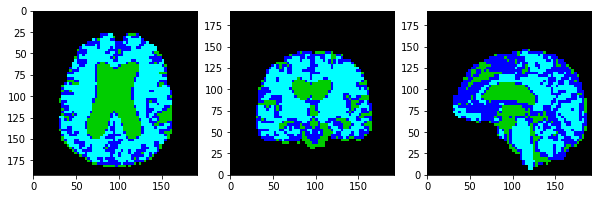

--------------------------------------------------
+ TRAINING 	Epoch: 181 	Loss: 0.768874
+ TRAINING 	Epoch: 182 	Loss: 0.768547
+ TRAINING 	Epoch: 183 	Loss: 0.766467
+ TRAINING 	Epoch: 184 	Loss: 0.768465
+ TRAINING 	Epoch: 185 	Loss: 0.767521
+ TRAINING 	Epoch: 186 	Loss: 0.767862
+ TRAINING 	Epoch: 187 	Loss: 0.769083
+ TRAINING 	Epoch: 188 	Loss: 0.766840
+ TRAINING 	Epoch: 189 	Loss: 0.769694
+ TRAINING 	Epoch: 190 	Loss: 0.769671
--------------------------------------------------
+ VALIDATE 	Epoch: 190 	Loss: 0.769571 	Time: 3247.322600
DSC	0.8884704776655381


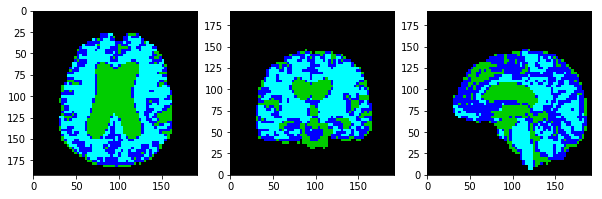

--------------------------------------------------
+ TRAINING 	Epoch: 191 	Loss: 0.767787
+ TRAINING 	Epoch: 192 	Loss: 0.768885
+ TRAINING 	Epoch: 193 	Loss: 0.769389
+ TRAINING 	Epoch: 194 	Loss: 0.767913
+ TRAINING 	Epoch: 195 	Loss: 0.769795
+ TRAINING 	Epoch: 196 	Loss: 0.766930
+ TRAINING 	Epoch: 197 	Loss: 0.766452
+ TRAINING 	Epoch: 198 	Loss: 0.767506
+ TRAINING 	Epoch: 199 	Loss: 0.769548
+ TRAINING 	Epoch: 200 	Loss: 0.766161
--------------------------------------------------
+ VALIDATE 	Epoch: 200 	Loss: 0.770328 	Time: 3418.236503
DSC	0.8845790670330633


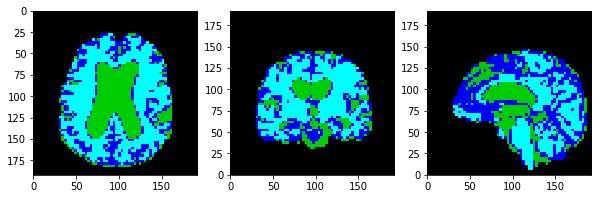

--------------------------------------------------

Finished TRAINING.


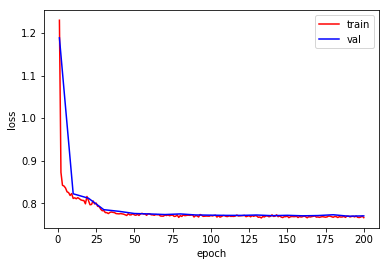

In [111]:
import time
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fixed random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
start = time.time()

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        d_score = 0
        idx_test = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
                sample = dataset_val.get_sample(idx_test)
                prd = torch.argmax(prd, dim=1)
                prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
                prediction.CopyInformation(sample['seg'])
                segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
                segmentation.CopyInformation(sample['seg'])
                overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
                overlap_measures_filter.Execute(prediction, segmentation)
                d_score += overlap_measures_filter.GetDiceCoefficient()
                
                
                idx_test += 1
                

        loss_val /= sum_pts
        avg_d_score = d_score / idx_test

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tTime: {:6f}'.format(epoch, loss_val, time.time()-start))
        print('DSC\t' + str(avg_d_score))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

In [12]:
# USE THIS FOR TESTING ON THE 600 SUBJECTS
test_data = data_dir + 'csv/test.csv'

# USE THIS FOR TESTING ON THE 5 VALIDATION SUBJECTS
# test_data = data_dir + 'train/csv/val.csv'

print('LOADING TESTING DATA...')
dataset_test = ImageSegmentationDataset(test_data, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

LOADING TESTING DATA...
+ reading image msub-CC110033_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110033.nii.gz
+ reading mask sub-CC110033_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110037_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110037.nii.gz
+ reading mask sub-CC110037_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110045_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110045.nii.gz
+ reading mask sub-CC110045_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110056_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110056.nii.gz
+ reading mask sub-CC110056_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110062_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110062.nii.gz
+ reading mask sub-CC110062_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110069_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC110069.nii.gz
+ reading mask sub-CC110069_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC110087_T1w_rigid_

+ reading image msub-CC121479_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121479.nii.gz
+ reading mask sub-CC121479_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC121685_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121685.nii.gz
+ reading mask sub-CC121685_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC121795_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC121795.nii.gz
+ reading mask sub-CC121795_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC122172_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC122172.nii.gz
+ reading mask sub-CC122172_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC122620_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC122620.nii.gz
+ reading mask sub-CC122620_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC210023_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC210023.nii.gz
+ reading mask sub-CC210023_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC210051_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC221033_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221033.nii.gz
+ reading mask sub-CC221033_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221038_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221038.nii.gz
+ reading mask sub-CC221038_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221040_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221040.nii.gz
+ reading mask sub-CC221040_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221054_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221054.nii.gz
+ reading mask sub-CC221054_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221107_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221107.nii.gz
+ reading mask sub-CC221107_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221209_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC221209.nii.gz
+ reading mask sub-CC221209_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC221244_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC310256_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310256.nii.gz
+ reading mask sub-CC310256_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310331_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310331.nii.gz
+ reading mask sub-CC310331_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310361_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310361.nii.gz
+ reading mask sub-CC310361_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310385_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310385.nii.gz
+ reading mask sub-CC310385_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310391_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310391.nii.gz
+ reading mask sub-CC310391_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310397_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC310397.nii.gz
+ reading mask sub-CC310397_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC310400_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC320776_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320776.nii.gz
+ reading mask sub-CC320776_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320814_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320814.nii.gz
+ reading mask sub-CC320814_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320850_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320850.nii.gz
+ reading mask sub-CC320850_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320870_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320870.nii.gz
+ reading mask sub-CC320870_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320888_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320888.nii.gz
+ reading mask sub-CC320888_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320893_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC320893.nii.gz
+ reading mask sub-CC320893_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC320904_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC410226_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410226.nii.gz
+ reading mask sub-CC410226_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410248_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410248.nii.gz
+ reading mask sub-CC410248_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410251_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410251.nii.gz
+ reading mask sub-CC410251_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410284_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410284.nii.gz
+ reading mask sub-CC410284_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410287_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410287.nii.gz
+ reading mask sub-CC410287_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410289_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC410289.nii.gz
+ reading mask sub-CC410289_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC410297_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC420412_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420412.nii.gz
+ reading mask sub-CC420412_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420433_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420433.nii.gz
+ reading mask sub-CC420433_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420435_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420435.nii.gz
+ reading mask sub-CC420435_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420462_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420462.nii.gz
+ reading mask sub-CC420462_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420464_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420464.nii.gz
+ reading mask sub-CC420464_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420493_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC420493.nii.gz
+ reading mask sub-CC420493_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC420566_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC510568_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC510568.nii.gz
+ reading mask sub-CC510568_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC510609_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC510609.nii.gz
+ reading mask sub-CC510609_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC510629_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC510629.nii.gz
+ reading mask sub-CC510629_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC510648_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC510648.nii.gz
+ reading mask sub-CC510648_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC512003_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC512003.nii.gz
+ reading mask sub-CC512003_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC520011_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC520011.nii.gz
+ reading mask sub-CC520011_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC520013_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC610028_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610028.nii.gz
+ reading mask sub-CC610028_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610039_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610039.nii.gz
+ reading mask sub-CC610039_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610040_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610040.nii.gz
+ reading mask sub-CC610040_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610046_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610046.nii.gz
+ reading mask sub-CC610046_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610050_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610050.nii.gz
+ reading mask sub-CC610050_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610051_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC610051.nii.gz
+ reading mask sub-CC610051_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC610052_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC620284_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620284.nii.gz
+ reading mask sub-CC620284_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620314_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620314.nii.gz
+ reading mask sub-CC620314_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620354_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620354.nii.gz
+ reading mask sub-CC620354_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620359_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620359.nii.gz
+ reading mask sub-CC620359_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620405_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620405.nii.gz
+ reading mask sub-CC620405_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620406_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC620406.nii.gz
+ reading mask sub-CC620406_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC620413_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC710429_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710429.nii.gz
+ reading mask sub-CC710429_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710446_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710446.nii.gz
+ reading mask sub-CC710446_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710462_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710462.nii.gz
+ reading mask sub-CC710462_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710486_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710486.nii.gz
+ reading mask sub-CC710486_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710494_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710494.nii.gz
+ reading mask sub-CC710494_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710518_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC710518.nii.gz
+ reading mask sub-CC710518_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC710548_T1w_rigid_to_mni.nii.gz
+ reading 

+ reading image msub-CC721585_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721585.nii.gz
+ reading mask sub-CC721585_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721618_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721618.nii.gz
+ reading mask sub-CC721618_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721648_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721648.nii.gz
+ reading mask sub-CC721648_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721704_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721704.nii.gz
+ reading mask sub-CC721704_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721707_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721707.nii.gz
+ reading mask sub-CC721707_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721729_T1w_rigid_to_mni.nii.gz
+ reading segmentation CC721729.nii.gz
+ reading mask sub-CC721729_T1w_rigid_to_mni_brain_mask.nii.gz
+ reading image msub-CC721888_T1w_rigid_to_mni.nii.gz
+ reading 

#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: msub-CC110033_T1w_rigid_to_mni.nii.gz


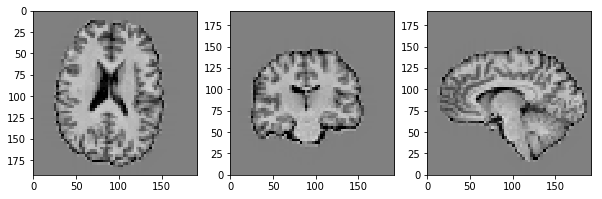

Segmentation: CC110033.nii.gz


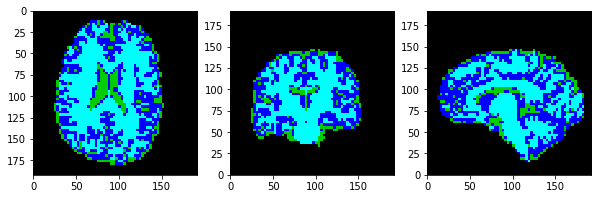

Mask


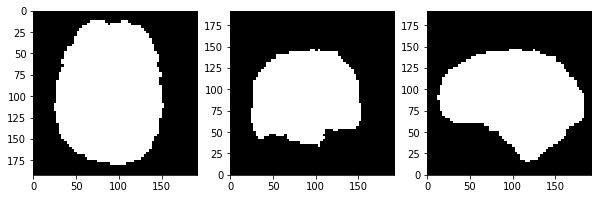

In [13]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation: ' + seg_name)
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

START TESTING...
+ TESTING: 	Idx: 40
+ TESTING: 	Idx: 80
+ TESTING: 	Idx: 120
+ TESTING: 	Idx: 160
+ TESTING: 	Idx: 200
+ TESTING: 	Idx: 240
+ TESTING: 	Idx: 280
+ TESTING: 	Idx: 320
+ TESTING: 	Idx: 360
+ TESTING: 	Idx: 400
+ TESTING: 	Idx: 440
+ TESTING: 	Idx: 480
+ TESTING: 	Idx: 520
+ TESTING: 	Idx: 560
+ TESTING: 	Idx: 600
+ TESTING 	Loss: 0.767359, 	Avg Dice Score: 0.887529, 	Avg f1 Score : 0.975770


Reference segmentation


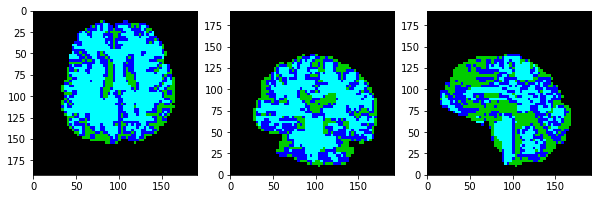

Predicted segmentation


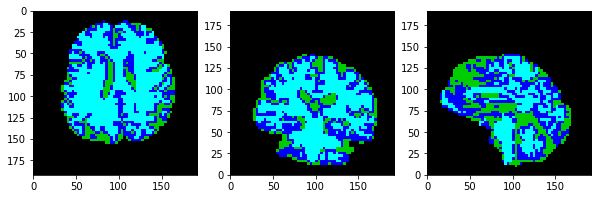


Finished TESTING.


In [92]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# model = SimpleNet3D(num_classes=num_classes)
# model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
d_score = 0
skd_score = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)
        
        prd = torch.argmax(prd, dim=1)
        # Dice Score

        prd_d = prd.view(prd.size()[0], -1)
        seg_d = seg.view(seg.size()[0], -1)
        skd_score += metrics.f1_score(seg_d.cpu().squeeze(), prd_d.cpu().squeeze(), average='weighted')
        
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        
        # Dice Score
        prediction.CopyInformation(sample['seg'])
        segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        segmentation.CopyInformation(sample['seg'])
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_measures_filter.Execute(prediction, segmentation)
        d_score += overlap_measures_filter.GetDiceCoefficient()
        
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        if (idx_test % 40 == 0):
            print('+ TESTING: \tIdx: {}'.format(idx_test))
        
loss_test /= sum_pts
avg_d_score = d_score / idx_test
avg_skd_score = skd_score.item() / idx_test

print('+ TESTING \tLoss: {:.6f}, \tAvg Dice Score: {:.6f}, \tAvg f1 Score : {:.6f}'.format(loss_test, avg_d_score, avg_skd_score))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

In [91]:
# Use this block to save or load models
# model_loc = 'regression_model.pt'
# torch.save(model.state_dict(), model_loc)
# model = SimpleNet3D(num_classes=num_classes)
# model.load_state_dict(torch.load(model_loc, map_location=device))

### Feature calculation

In [93]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os
from utils.data_helper import resample_image
import collections

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
# seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
seg_dir = data_dir + './segs_refs/'

vols_given = np.zeros((3,meta_data['ID'].count()))
for i in range(meta_data['ID'].count()):

    if (i % 50 == 0):
        print("Loading given:\t{}".format(i))
    ID = meta_data['ID'][i]
    seg = sitk.ReadImage(seg_dir+ID+'.nii.gz')
    seg=resample_image(seg,img_spacing,img_size, is_label=True)
    seg_array = sitk.GetArrayFromImage(seg)
    seg_transformed = seg_array.flatten().squeeze()
    freq = collections.Counter(seg_transformed)
    
    x, y, z = seg.GetSpacing()  
    vols_given[:,i] = freq[1]*x*y*z, freq[2]*x*y*z, freq[3]*x*y*z

seg_dir = './output/pred/'
vols_our = np.zeros((3,meta_data['ID'].count()))
for i in range(meta_data['ID'].count()):

    if (i % 50 == 0):
        print("Loading our:\t{}".format(i))
    ID = meta_data['ID'][i]
    seg = sitk.ReadImage(seg_dir+ID+'.nii.gz')
    seg=resample_image(seg,img_spacing,img_size, is_label=True)
    seg_array = sitk.GetArrayFromImage(seg)
    seg_transformed = seg_array.flatten().squeeze()
    freq = collections.Counter(seg_transformed)
    
    x, y, z = seg.GetSpacing()  
    vols_our[:,i] = freq[1]*x*y*z, freq[2]*x*y*z, freq[3]*x*y*z

Loading given:	0
Loading given:	50
Loading given:	100
Loading given:	150
Loading given:	200
Loading given:	250
Loading given:	300
Loading given:	350
Loading given:	400
Loading given:	450
Loading given:	500
Loading given:	550
Loading our:	0
Loading our:	50
Loading our:	100
Loading our:	150
Loading our:	200
Loading our:	250
Loading our:	300
Loading our:	350
Loading our:	400
Loading our:	450
Loading our:	500
Loading our:	550


Plot features versus age.

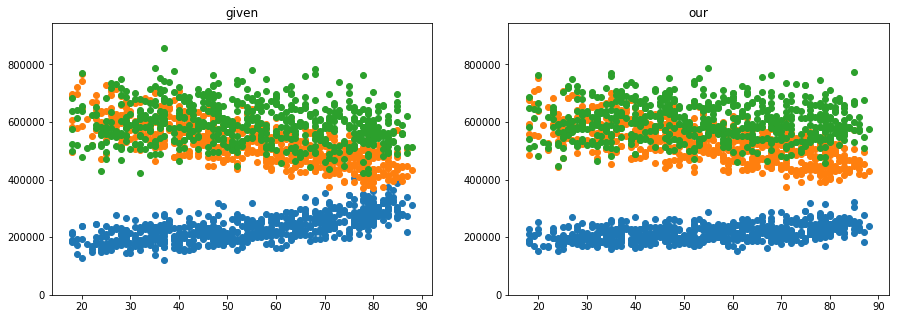

In [96]:
age = meta_data['age']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
height = np.max(vols_given) if np.max(vols_given) \
    >= np.max(vols_our) else np.max(vols_our)
height *= 1.1
ax1.scatter(age, vols_given[0, :])
ax1.scatter(age, vols_given[1, :])
ax1.scatter(age, vols_given[2, :])
ax1.set_ybound(0,height)
ax1.set_title("given")
ax2.scatter(age, vols_our[0, :])
ax2.scatter(age, vols_our[1, :])
ax2.scatter(age, vols_our[2, :])
ax2.set_ybound(0,height)
ax2.set_title("our")
plt.show()

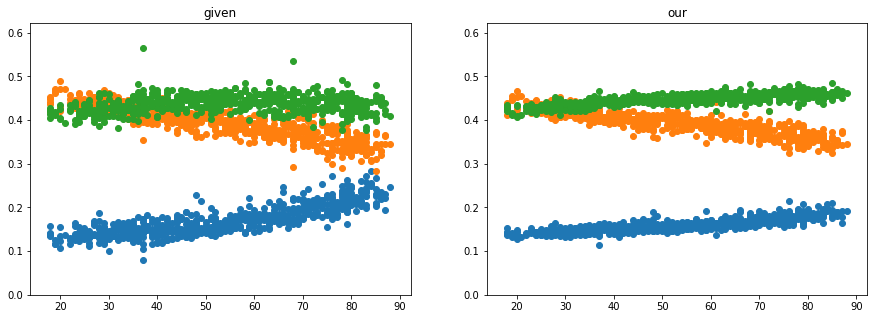

In [97]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_given_normalised = vols_given / (vols_given[0,:]+vols_given[1,:]+vols_given[2,:])
vols_normalised = vols_our / (vols_our[0,:]+vols_our[1,:]+vols_our[2,:])
height = np.max(vols_given_normalised) if np.max(vols_given_normalised) \
        >= np.max(vols_normalised) else np.max(vols_normalised)
height *= 1.1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(age, vols_given_normalised[0, :])
ax1.scatter(age, vols_given_normalised[1, :])
ax1.scatter(age, vols_given_normalised[2, :])
ax1.set_ybound(0,height)
ax1.set_title("given")
ax2.scatter(age, vols_normalised[0, :])
ax2.scatter(age, vols_normalised[1, :])
ax2.scatter(age, vols_normalised[2, :])
ax2.set_ybound(0,height)
ax2.set_title("our")
plt.show()

In [98]:
X = vols_normalised.T
y = meta_data['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(600, 3)
(600, 1)


### Age regression and cross-validation

In [99]:
def display_pred(preds, y, info=None):
    preds = np.array(preds)
    height = np.max(preds) if np.max(preds) >= np.max(y) else np.max(y)
    height *= 1.1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.scatter(y, y)
    ax1.scatter(y, preds[0,:])
    ax1.set_ybound(0,height)

    ax2.scatter(y, y)
    ax2.scatter(y, preds[1,:])
    ax2.set_ybound(0,height)
    
    if info != None:
        ax1.set_title(info + " on 1-st fold")
        ax2.set_title(info + " on 2-nd fold")
        
    plt.show()
    

Linear Regression:	mae=7.813750	r2=0.748598
Poly Regression:	mae=7.736667	r2=0.751389
KNNeighbour Regression:	mae=7.839167	r2=0.730045
Ridge Regression:	mae=7.830806	r2=0.747908

Linear Regression:	mae=7.216667	r2=0.734137
Poly Regression:	mae=7.310000	r2=0.731111
KNNeighbour Regression:	mae=7.636667	r2=0.694060
Ridge Regression:	mae=7.087022	r2=0.742334



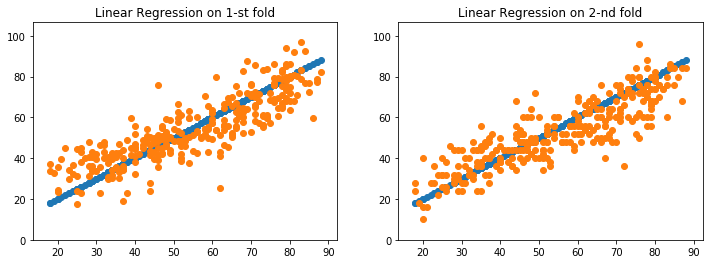

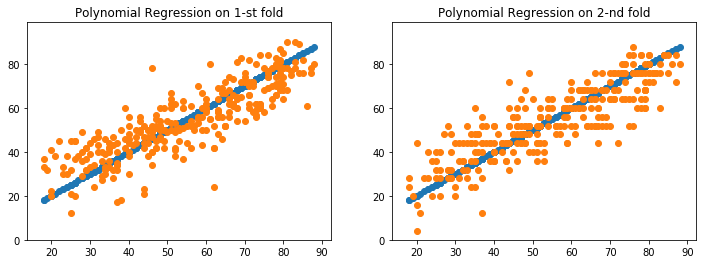

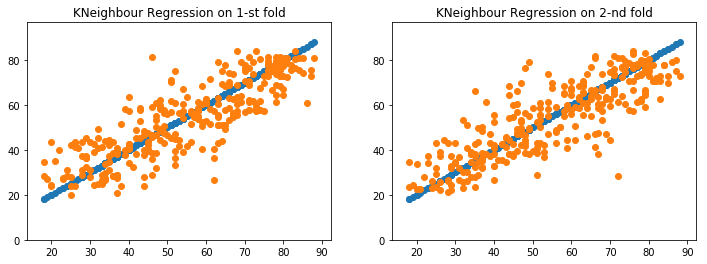

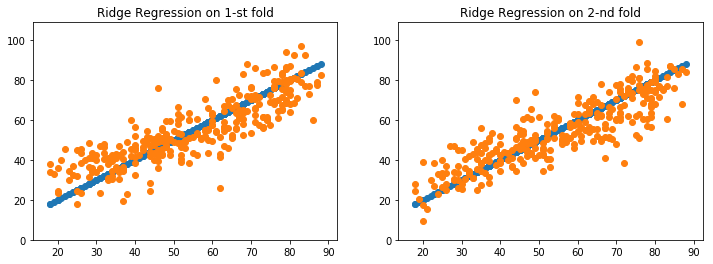

In [100]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

y = y.squeeze()

linear_preds = []
poly_preds = []
knn_preds = []
ridge_preds =[]
kf = KFold(n_splits=2, random_state = rnd_seed, shuffle=True)
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    #print(X_train.shape)
    
    # Linear Regression
    reg = linear_model.LinearRegression(normalize=True)
    reg.fit(X_train, y_train)
    linear_pred = reg.predict(X_test)
    linear_preds.append(linear_pred)
    mae = mean_absolute_error(y_test, linear_pred)
    r2 = r2_score(y_test, linear_pred)
    print("Linear Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    clf = linear_model.LinearRegression(normalize=True)
    clf.fit(X_train_poly, y_train)
    pred = clf.predict(X_test_poly)
    poly_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("Poly Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    # KNN Regression
    knn = KNeighborsRegressor(n_neighbors=4, algorithm='auto')
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    knn_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("KNNeighbour Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    # Bayesian Ridge Regression
    br = BayesianRidge(normalize=True)
    br.fit(X_train, y_train)
    pred = br.predict(X_test)
    ridge_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("Ridge Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    print()
    
display_pred(linear_preds, y_test, info="Linear Regression")
display_pred(poly_preds, y_test, info="Polynomial Regression")
display_pred(knn_preds, y_test, info="KNeighbour Regression")
display_pred(ridge_preds, y_test, info="Ridge Regression")

## Image-based regression using grey matter maps

### Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it is beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation that had been applied to the maps.

Because the maps are quite large, it is also worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues.

In [85]:
# Pre-processing
# Gaussian smoothing and downsampling

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
grey_dir = data_dir + './greymatter/'

def downsample(img, factor=2):
    smoothed = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
    return smoothed[::factor, ::factor, ::factor]

# img_size = [64, 64, 64]

write_image = True
grey_out = os.path.join(out_dir, 'grey')
if not os.path.exists(grey_out):
    os.makedirs(grey_out)

img_data = []
for i in range(meta_data['ID'].count()):
# for i in range(50):
    ID = meta_data['ID'][i]
    file_name = ID +  '.nii.gz'
    if (i % 50 == 0):
        print("Loading: \t{}".format(i))
    if write_image:
        #seg = sitk.ReadImage(seg_dir+ID+'.nii.gz')
        #seg=resample_image(seg,img_spacing,img_size)
        img = sitk.Cast(sitk.ReadImage(grey_dir+'wc1sub-'+ID+'_T1w_rigid_to_mni.nii.gz'), sitk.sitkFloat32) #wc1sub-CC110033_T1w_rigid_to_mni.nii.gz
        img_size = [np.min(img.GetSize()).item()]*3
        #         print(img.GetSize(), "original")
#         display_image(img)
        
        # Resample the image
#         img = resample_image(img, out_spacing = img_spacing, out_size = img_size, is_label=True)
#         print(img.GetSize(), "resampled")
#         display_image(img)
        # Gaussian smoothing
#         img_downsample = downsample(img_resample, factor=2)
        factor = 2
#         img = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
#         img = img[::factor, ::factor, ::factor]
        img = downsample(img, factor)
        img_size = img.GetSize()
#         img_gauss = sitk.DiscreteGaussian(img_resample, 1)
#         print("gaussian-ed")
#         display_image(img_gauss)
#         img_down_1 = downsample(img_gauss)
#         print(img.GetSize(), "down-sampled")
#         display_image(img)
        #print(os.path.join(out_dir, file_name))
        sitk.WriteImage(img, os.path.join(grey_out, file_name))
    
    else:    
        img = sitk.ReadImage(os.path.join(grey_out, file_name))
        img_size = img.GetSize()
        
    img_array = sitk.GetArrayFromImage(img) # Convert the SimpleITK image to a NumPy array
    
    img_transformed = img_array.flatten().squeeze()
    img_data.append(img_transformed)
    
img_data = np.array(img_data)
print("Loading finished. Loaded data size is: {}".format(img_data.shape))

Loading: 	0
Loading: 	50
Loading: 	100
Loading: 	150
Loading: 	200
Loading: 	250
Loading: 	300
Loading: 	350
Loading: 	400
Loading: 	450
Loading: 	500
Loading: 	550
Loading finished. Loaded data size is: (600, 109350)


(45, 54, 45)
(600, 109350)
(600, 1)


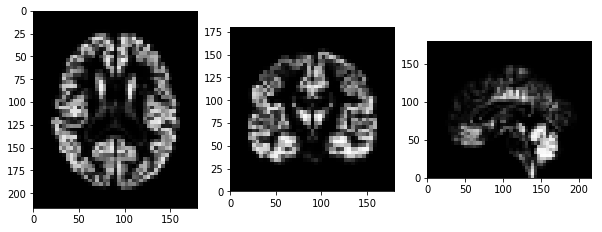

In [86]:
X = img_data #PRE-PROCESSED IMAGE DATA
y = meta_data['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

display_image(img)


### Dimensionality reduction

In [87]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = rnd_seed)

pca = PCA(n_components = 0.95, random_state=rnd_seed)
print("fitting train set")
pca.fit(X_train)
print("transforming train set")
X_train_transformed = pca.transform(X_train)

print("transforming test set")
X_test_transformed = pca.transform(X_test)

# print("evaluating train")
# print(pca.score(X_train))
# print("evaluating test")
# print(pca.score(X_test))

fitting train set
transforming train set
transforming test set


### Age regression and cross-validation

Linear Regression:	mae=5.744854	r2=0.857178
Poly Regression:	mae=13.689005	r2=0.310770
KNNeighbour Regression:	mae=7.550833	r2=0.757745
Ridge Regression:	mae=5.968928	r2=0.849762

Linear Regression:	mae=5.372419	r2=0.868518
Poly Regression:	mae=12.710742	r2=0.345545
KNNeighbour Regression:	mae=7.653333	r2=0.726163
Ridge Regression:	mae=5.499683	r2=0.862488



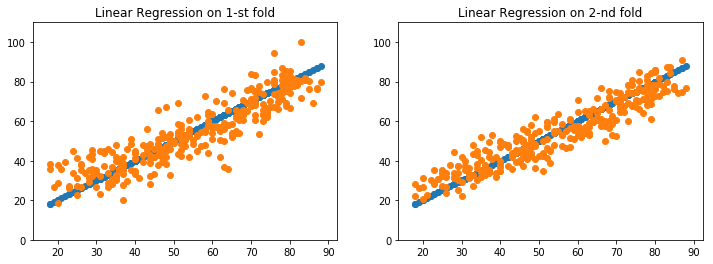

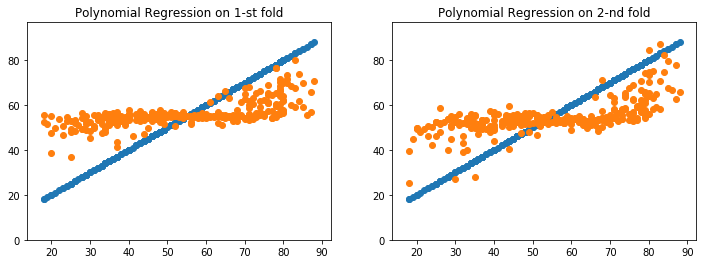

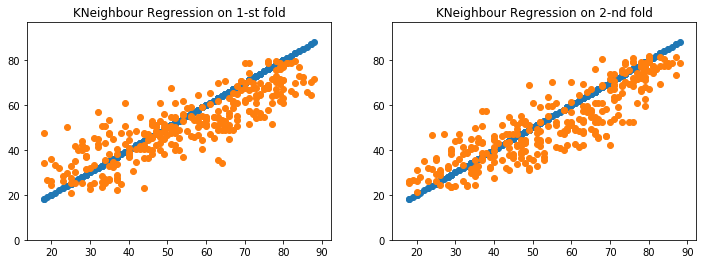

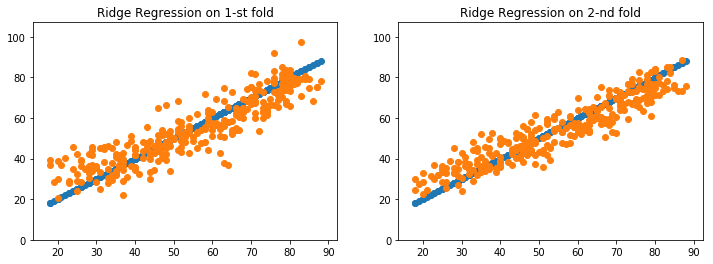

In [88]:
y = y.squeeze()

# X, y = shuffle(X, y)

linear_preds = []
poly_preds = []
knn_preds = []
ridge_preds =[]

kf = KFold(n_splits=2, random_state = rnd_seed, shuffle=True)
#rkf = RepeatedKFold(n_splits=2, n_repeats=1, random_state=rnd_seed)
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

    pca = PCA(n_components = 0.95) # 0.95 linear mae 15.28473323363056
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)
    
    # Linear Regression
    reg = linear_model.LinearRegression()
    reg.fit(X_train_transformed, y_train)
    linear_pred = reg.predict(X_test_transformed)
    linear_preds.append(linear_pred)
    mae = mean_absolute_error(y_test, linear_pred)
    r2 = r2_score(y_test, linear_pred)
    print("Linear Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_transformed)
    X_test_poly = poly.fit_transform(X_test_transformed)

    clf = linear_model.LinearRegression()
    clf.fit(X_train_poly, y_train)
    pred = clf.predict(X_test_poly)
    poly_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("Poly Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    # KNN Regression
    knn = KNeighborsRegressor(n_neighbors=4, algorithm='auto')
    knn.fit(X_train_transformed, y_train)
    pred = knn.predict(X_test_transformed)
    knn_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("KNNeighbour Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))

    # Bayesian Ridge Regression
    br = BayesianRidge(normalize=True)
    br.fit(X_train_transformed, y_train)
    pred = br.predict(X_test_transformed)
    ridge_preds.append(pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("Ridge Regression:\tmae={:.6f}\tr2={:.6f}".format(mae, r2))
    
    print()

display_pred(linear_preds, y_test, info="Linear Regression")
display_pred(poly_preds, y_test, info="Polynomial Regression")
display_pred(knn_preds, y_test, info="KNeighbour Regression")
display_pred(ridge_preds, y_test, info="Ridge Regression")